In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn import linear_model
# from __future__ import division

%matplotlib inline
seaborn.set()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

G:\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
G:\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
G:\Anaconda3\lib\site

In [2]:
# 确诊数据导入
f_confirm = open(r'time_series_covid19_confirmed_global.csv',encoding = "utf-8")
data_confirm = pd.read_csv(f_confirm,header=None)

In [3]:
# 整理原csv的格式，并提取所需信息，计算R0
def formatTransform(data):
    # 修改日期的格式
    rows,cols = data.shape
    for col in range(4,cols):
        ls_date = data.iloc[0,col].split('/')
        data.iloc[0,col] = '20{}/{}/{}'.format(ls_date[2],ls_date[0],ls_date[1])
    
    # 整合整个国家的信息
    data.drop([0,2,3],axis=1,inplace=True)  # 删除州列和经纬度列
    country = data.iloc[:,0].drop_duplicates(keep='first')   # 保存国家名
    data.iloc[1:,1:] = data.iloc[1:,1:].astype('int64')
    data = data.groupby(1).transform(sum)   # 把原本按州分列的信息按国家汇总
    data.insert(0,0,country)                # 还原国家名
    # 整理索引
    data.columns = data.iloc[0,:]
    data.drop([0],axis=0,inplace=True)
    data = data.reset_index(drop=True)
    data = data[data['Country/Region'].notnull()]
    return data

In [4]:
# 带入函数，整理格式
data_confirm = formatTransform(data_confirm)
data_confirm = data_confirm.reset_index(drop=True)
data_confirm

0        Country/Region 2020/1/22 2020/1/23 2020/1/24 2020/1/25 2020/1/26  \
0           Afghanistan         0         0         0         0         0   
1               Albania         0         0         0         0         0   
2               Algeria         0         0         0         0         0   
3               Andorra         0         0         0         0         0   
4                Angola         0         0         0         0         0   
..                  ...       ...       ...       ...       ...       ...   
187             Vietnam         0         2         2         2         2   
188  West Bank and Gaza         0         0         0         0         0   
189               Yemen         0         0         0         0         0   
190              Zambia         0         0         0         0         0   
191            Zimbabwe         0         0         0         0         0   

0   2020/1/27 2020/1/28 2020/1/29 2020/1/30  ... 2021/1/16 2021/1/17  \
0           0         0         0         0  ...     53938     53984   
1           0         0         0         0  ...     67216     67690   
2           0         0         0         0  ...    103611    103833   
3           0         0         0         0  ...      9038      9083   
4           0         0         0         0  ...     18765     18875   
..        ...       ...       ...       ...  ...       ...       ...   
187         2         2         2         2  ...      1537      1537   
188         0         0         0         0  ...    151569    152031   
189         0         0         0         0  ...      2112      2112   
190         0         0         0         0  ...     36074     37605   
191         0         0         0         0  ...     26881     27203   

0   2021/1/18 2021/1/19 2021/1/20 2021/1/21 2021/1/22 2021/1/23 2021/1/24  \
0       54062     54141     54278     54403     54483     54559     54595   
1       67982     68568     69238     69916     70655     71441     72274   
2      104092    104341    104606    104852    105124    105369    105596   
3        9083      9194      9308      9379      9416      9499      9549   
4       18926     19011     19093     19177     19269     19367     19399   
..        ...       ...       ...       ...       ...       ...       ...   
187      1539      1540      1544      1546      1548      1548      1548   
188    152555    153093    153590    154063    154557    155006    155414   
189      2113      2115      2115      2115      2118      2118      2118   
190     38207     39515     40949     42213     43333     44592     45337   
191     27892     28675     29408     30047     30523     31007     31320   

0   2021/1/25  
0       54672  
1       72812  
2      105854  
3        9596  
4       19476  
..        ...  
187      1549  
188    155884  
189      2118  
190     46146  
191     31646  

[192 rows x 371 columns]

In [5]:
# 找一个国家确诊到达50的日期
def confirm50Date(country):
    subdata = data_confirm[data_confirm['Country/Region']==country]
    for col in range(1,subdata.shape[1]):
        date = '2020/12/31'
        if subdata.iloc[0,col] >= 50:
            date = list(subdata.columns)[col]
            break
    return date

In [6]:
# 各国累计确诊达到100的时间 和 2020年底累计确诊人数
ls_country = list(data_confirm['Country/Region'])
data_scatter = pd.DataFrame()
data_scatter['Country/Region'] = data_confirm['Country/Region']
data_scatter['Confirm'] = data_confirm['2020/12/31']
data_scatter['50Date'] = 0
ls_date = []
for country in ls_country:
    date = confirm50Date(country)
    ls_date.append(date)
data_scatter['50Date'] = pd.to_datetime(ls_date)
data_scatter

Country/Region Confirm     50Date
0           Afghanistan   51526 2020-03-25
1               Albania   58316 2020-03-16
2               Algeria   99610 2020-03-16
3               Andorra    8049 2020-03-19
4                Angola   17553 2020-05-18
..                  ...     ...        ...
187             Vietnam    1465 2020-03-14
188  West Bank and Gaza  138004 2020-03-22
189               Yemen    2099 2020-05-10
190              Zambia   20725 2020-04-17
191            Zimbabwe   13867 2020-05-21

[192 rows x 3 columns]

In [7]:
# 政策数据导入
f_policy = open(r'OxCGRT_latest.csv',encoding="utf-8")
data_policy = pd.read_csv(f_policy)

C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# 对政策指标的二值化更改
# 封闭措施
# C1
data_policy['C1'] = 0
data_policy['C1'][data_policy['C1_School closing']<=1.0] = 0
data_policy['C1'][data_policy['C1_School closing']>=2.0] = 1
# C2
data_policy['C2'] = 0
data_policy['C2'][data_policy['C2_Workplace closing']<=1.0] = 0
data_policy['C2'][data_policy['C2_Workplace closing']>=2.0] = 1
# C3
data_policy['C3'] = 0
data_policy['C3'][data_policy['C3_Cancel public events']>=1.0] = 1
# C4
data_policy['C4'] = 0
data_policy['C4'][data_policy['C4_Restrictions on gatherings']<=3.0] = 0
data_policy['C4'][data_policy['C4_Restrictions on gatherings']>=4.0] = 1
# C5
data_policy['C5'] = 0
data_policy['C5'][data_policy['C5_Close public transport']<=1.0] = 0
data_policy['C5'][data_policy['C5_Close public transport']>=2.0] = 1
# C6
data_policy['C6'] = 0
data_policy['C6'][data_policy['C6_Stay at home requirements']<=1.0] = 0
data_policy['C6'][data_policy['C6_Stay at home requirements']>=2.0] = 1
# C7
data_policy['C7'] = 0
data_policy['C7'][data_policy['C7_Restrictions on internal movement']<=1.0] = 0
data_policy['C7'][data_policy['C7_Restrictions on internal movement']>=2.0] = 1
# C8
data_policy['C8'] = 0
data_policy['C8'][data_policy['C8_International travel controls']<=1.0] = 0
data_policy['C8'][data_policy['C8_International travel controls']>=2.0] = 1

# 经济政策
# E1
data_policy['E1'] = 0
data_policy['E1'][data_policy['E1_Income support']>=1.0] = 1
# E2
data_policy['E2'] = 0
data_policy['E2'][data_policy['E2_Debt/contract relief']<=1.0] = 0
data_policy['E2'][data_policy['E2_Debt/contract relief']>=2.0] = 1
# E3
data_policy['E3'] = 0
data_policy['E3'][data_policy['E3_Fiscal measures']<1e+07] = 0
data_policy['E3'][data_policy['E3_Fiscal measures']>=1e+07] = 1
# E4
data_policy['E4'] = 0
data_policy['E4'][data_policy['E4_International support']<1e+05] = 0
data_policy['E4'][data_policy['E4_International support']>=1e+05] = 1

# 卫生系统政策
# H1
data_policy['H1'] = 0
data_policy['H1'][data_policy['H1_Public information campaigns']<=1.0] = 0
data_policy['H1'][data_policy['H1_Public information campaigns']>=2.0] = 1
# H2
data_policy['H2'] = 0
data_policy['H2'][data_policy['H2_Testing policy']<=1.0] = 0
data_policy['H2'][data_policy['H2_Testing policy']>=2.0] = 1
# H3
data_policy['H3'] = 0
data_policy['H3'][data_policy['H3_Contact tracing']<=1.0] = 0
data_policy['H3'][data_policy['H3_Contact tracing']>=2.0] = 1
# H4
data_policy['H4'] = 0
data_policy['H4'][data_policy['H4_Emergency investment in healthcare']<1e+06] = 0
data_policy['H4'][data_policy['H4_Emergency investment in healthcare']>=1e+06] = 1
# H5
data_policy['H5'] = 0
data_policy['H5'][data_policy['H5_Investment in vaccines']<1e+06] = 0
data_policy['H5'][data_policy['H5_Investment in vaccines']>=1e+06] = 1
# H6
data_policy['H6'] = 0
data_policy['H6'][data_policy['H6_Facial Coverings']<=2.0] = 0
data_policy['H6'][data_policy['H6_Facial Coverings']>=3.0] = 1
# H7
data_policy['H7'] = 0
data_policy['H7'][data_policy['H7_Vaccination policy']<=3.0] = 0
data_policy['H7'][data_policy['H7_Vaccination policy']>=4.0] = 1

C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\zay\AppD

In [9]:
# 取国家水平的政策数据、筛选时间
data_policy = data_policy[data_policy['Jurisdiction'] == 'NAT_TOTAL']
data_policy['Date'] = pd.to_datetime(data_policy['Date'],format='%Y%m%d')
data_policy = data_policy[data_policy['Date']<='2020-12-31']

In [10]:
# 建立字典，对应政策代号及其中英文名
dic_policyEng = dict()
dic_policyChi = dict()

# 封闭措施
dic_policyEng['C1'] = 'School closing'
dic_policyChi['C1'] = '关闭学校'
dic_policyEng['C2'] = 'Workplace closing'
dic_policyChi['C2'] = '关闭工作场所'
dic_policyEng['C3'] = 'Cancel public events'
dic_policyChi['C3'] = '取消公共活动'
dic_policyEng['C4'] = 'Restrictions on gatherings'
dic_policyChi['C4'] = '限制集会'
dic_policyEng['C5'] = 'Close public transport'
dic_policyChi['C5'] = '关闭公共交通'
dic_policyEng['C6'] = 'Stay at home requirements'
dic_policyChi['C6'] = '居家要求'
dic_policyEng['C7'] = 'Restrictions on internal movement'
dic_policyChi['C7'] = '国内移动限制'
dic_policyEng['C8'] = 'International travel controls'
dic_policyChi['C8'] = '国际旅行控制'

# 经济政策
dic_policyEng['E1'] = 'Income support'
dic_policyChi['E1'] = '收入支持'
dic_policyEng['E2'] = 'Debt/contract relief'
dic_policyChi['E2'] = '债务/合同放宽'
dic_policyEng['E3'] = 'Fiscal measures'
dic_policyChi['E3'] = '财政措施'
dic_policyEng['E4'] = 'International support'
dic_policyChi['E4'] = '给予国际支持'

# 卫生系统政策
dic_policyEng['H1'] = 'Public information campaigns'
dic_policyChi['H1'] = '公共信息宣传'
dic_policyEng['H2'] = 'Testing policy'
dic_policyChi['H2'] = '检测政策'
dic_policyEng['H3'] = 'Contact tracing'
dic_policyChi['H3'] = '接触者追踪'
dic_policyEng['H4'] = 'Emergency investment in healthcare'
dic_policyChi['H4'] = '医疗保健紧急投资'
dic_policyEng['H5'] = 'Investment in vaccines'
dic_policyChi['H5'] = '疫苗投资'
dic_policyEng['H6'] = 'Facial Coverings'
dic_policyChi['H6'] = '口罩政策'
dic_policyEng['H7'] = 'Vaccination Policy'
dic_policyChi['H7'] = '疫苗接种政策'

In [11]:
# 政策编号列表
ls_code = (dic_policyEng.keys())

In [12]:
# 是否引入政策
data_policy['policyExists'] = 0
data_policy['CExists'] = 0
data_policy['EExists'] = 0
data_policy['HExists'] = 0
for code in ls_code:
    data_policy['policyExists'] = data_policy['policyExists'] + data_policy[code]
    if code[0] == 'C':
        data_policy['CExists'] = data_policy['CExists'] + data_policy[code]
    elif code[0] == 'E':
        data_policy['EExists'] = data_policy['EExists'] + data_policy[code]
    elif code[0] == 'H':
        data_policy['HExists'] = data_policy['HExists'] + data_policy[code]

data_policy['policyExists'][data_policy['policyExists']>0] = 1
data_policy['CExists'][data_policy['CExists']>0] = 1
data_policy['EExists'][data_policy['EExists']>0] = 1
data_policy['HExists'][data_policy['HExists']>0] = 1

C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [13]:
data_policy.to_csv('国家聚类.csv',index=False,sep=',',encoding="utf_8_sig")

In [14]:
ls_dropCountry = []

In [15]:
# 初次采用政策的日期
def firstPolicyDate(country,policy):
    global ls_dropCountry
    if country not in list(data_policy['CountryName']):
        if country == 'Congo (Kinshasa)':
            country = 'Democratic Republic of Congo'
        elif country =='Congo (Brazzaville)':
            country = 'Congo'
        elif country == 'Korea, South':
            country == 'South Korea'
        elif country == 'US':
            country = 'United States'
        elif country == 'Taiwan*':
            country = 'Taiwan'
        else:
            # print(country)
            ls_dropCountry.append(country)
            return pd.to_datetime('2021-01-01')

    data_country = data_policy[data_policy['CountryName']==country]
    row = data_country.shape[0]
    date = pd.to_datetime('2021-01-01')
    for i in range(row):
        if data_country[policy].iloc[i] == 1:
            date = data_policy['Date'].iloc[i]
            break
    return date

In [16]:
ls_code = list(dic_policyEng.keys())
ls_code.extend(['policyExists','CExists','EExists','HExists'])
for code in ls_code:
    ls_policyDate = []
    for country in ls_country:
        date = firstPolicyDate(country,code)
        ls_policyDate.append(date)
    column = code + 'Date'
    data_scatter[column] = pd.Series(ls_policyDate)
data_scatter

Country/Region Confirm     50Date     C1Date     C2Date     C3Date  \
0           Afghanistan   51526 2020-03-25 2020-03-14 2020-03-24 2020-03-01   
1               Albania   58316 2020-03-16 2020-03-09 2020-03-11 2020-03-09   
2               Algeria   99610 2020-03-16 2020-03-12 2020-03-23 2020-03-10   
3               Andorra    8049 2020-03-19 2020-03-16 2020-03-14 2020-03-13   
4                Angola   17553 2020-05-18 2020-03-24 2020-03-27 2020-03-27   
..                  ...     ...        ...        ...        ...        ...   
187             Vietnam    1465 2020-03-14 2020-01-29 2020-03-25 2020-02-08   
188  West Bank and Gaza  138004 2020-03-22 2021-01-01 2021-01-01 2021-01-01   
189               Yemen    2099 2020-05-10 2020-03-15 2020-04-30 2020-03-17   
190              Zambia   20725 2020-04-17 2020-03-20 2020-05-02 2020-04-15   
191            Zimbabwe   13867 2020-05-21 2020-03-24 2020-03-30 2020-03-17   

        C4Date     C5Date     C6Date     C7Date  ...     H2Date     H3Date  \
0   2020-04-05 2020-03-28 2020-03-25 2020-04-12  ... 2020-08-18 2020-08-18   
1   2020-04-18 2020-03-13 2020-03-13 2020-03-13  ... 2020-04-21 2020-05-26   
2   2020-03-30 2020-03-23 2020-03-23 2020-03-23  ... 2021-01-01 2020-06-28   
3   2020-09-21 2021-01-01 2021-01-01 2021-01-01  ... 2020-04-18 2020-07-29   
4   2020-03-27 2020-03-27 2020-03-27 2020-03-27  ... 2020-04-01 2021-01-01   
..         ...        ...        ...        ...  ...        ...        ...   
187 2020-04-01 2020-03-28 2020-04-01 2020-02-13  ... 2020-02-07 2020-03-07   
188 2021-01-01 2021-01-01 2021-01-01 2021-01-01  ... 2021-01-01 2021-01-01   
189 2021-01-01 2021-01-01 2020-05-01 2020-04-30  ... 2021-01-01 2021-01-01   
190 2020-04-15 2021-01-01 2020-04-15 2020-04-14  ... 2020-11-16 2020-03-26   
191 2021-01-01 2021-01-01 2020-03-30 2020-03-30  ... 2021-01-01 2021-01-01   

        H4Date     H5Date     H6Date     H7Date policyExistsDate CExistsDate  \
0   2020-03-12 2021-01-01 2020-06-07 2021-01-01       2020-02-23  2020-02-23   
1   2020-02-25 2021-01-01 2020-07-15 2021-01-01       2020-02-25  2020-03-09   
2   2020-03-22 2021-01-01 2020-04-23 2021-01-01       2020-03-10  2020-03-10   
3   2020-03-30 2021-01-01 2020-07-15 2021-01-01       2020-02-27  2020-03-13   
4   2020-04-03 2021-01-01 2020-04-09 2021-01-01       2020-02-06  2020-02-06   
..         ...        ...        ...        ...              ...         ...   
187 2021-01-01 2021-01-01 2020-11-17 2021-01-01       2020-01-29  2020-01-29   
188 2021-01-01 2021-01-01 2021-01-01 2021-01-01       2021-01-01  2021-01-01   
189 2021-01-01 2021-01-01 2021-01-01 2021-01-01       2020-03-15  2020-03-15   
190 2020-03-28 2021-01-01 2020-04-16 2021-01-01       2020-02-21  2020-02-21   
191 2021-01-01 2021-01-01 2020-05-04 2021-01-01       2020-03-17  2020-03-17   

    EExistsDate HExistsDate  
0    2020-08-21  2020-03-01  
1    2020-03-19  2020-02-25  
2    2020-04-13  2020-03-22  
3    2020-02-27  2020-03-25  
4    2020-04-09  2020-04-01  
..          ...         ...  
187  2020-04-06  2020-01-29  
188  2021-01-01  2021-01-01  
189  2021-01-01  2021-01-01  
190  2020-03-28  2020-02-21  
191  2020-03-31  2020-03-27  

[192 rows x 26 columns]

In [17]:
for country in ls_dropCountry:
    data_scatter = data_scatter.drop(data_scatter[data_scatter['Country/Region']==country].index)
data_scatter = data_scatter.reset_index(drop=True)
data_scatter

Country/Region Confirm     50Date     C1Date     C2Date     C3Date  \
0      Afghanistan   51526 2020-03-25 2020-03-14 2020-03-24 2020-03-01   
1          Albania   58316 2020-03-16 2020-03-09 2020-03-11 2020-03-09   
2          Algeria   99610 2020-03-16 2020-03-12 2020-03-23 2020-03-10   
3          Andorra    8049 2020-03-19 2020-03-16 2020-03-14 2020-03-13   
4           Angola   17553 2020-05-18 2020-03-24 2020-03-27 2020-03-27   
..             ...     ...        ...        ...        ...        ...   
162      Venezuela  113558 2020-03-21 2020-03-16 2020-03-16 2020-03-12   
163        Vietnam    1465 2020-03-14 2020-01-29 2020-03-25 2020-02-08   
164          Yemen    2099 2020-05-10 2020-03-15 2020-04-30 2020-03-17   
165         Zambia   20725 2020-04-17 2020-03-20 2020-05-02 2020-04-15   
166       Zimbabwe   13867 2020-05-21 2020-03-24 2020-03-30 2020-03-17   

        C4Date     C5Date     C6Date     C7Date  ...     H2Date     H3Date  \
0   2020-04-05 2020-03-28 2020-03-25 2020-04-12  ... 2020-08-18 2020-08-18   
1   2020-04-18 2020-03-13 2020-03-13 2020-03-13  ... 2020-04-21 2020-05-26   
2   2020-03-30 2020-03-23 2020-03-23 2020-03-23  ... 2021-01-01 2020-06-28   
3   2020-09-21 2021-01-01 2021-01-01 2021-01-01  ... 2020-04-18 2020-07-29   
4   2020-03-27 2020-03-27 2020-03-27 2020-03-27  ... 2020-04-01 2021-01-01   
..         ...        ...        ...        ...  ...        ...        ...   
162 2020-05-13 2020-06-22 2020-03-13 2020-03-13  ... 2020-05-08 2021-01-01   
163 2020-04-01 2020-03-28 2020-04-01 2020-02-13  ... 2020-02-07 2020-03-07   
164 2021-01-01 2021-01-01 2020-05-01 2020-04-30  ... 2021-01-01 2021-01-01   
165 2020-04-15 2021-01-01 2020-04-15 2020-04-14  ... 2020-11-16 2020-03-26   
166 2021-01-01 2021-01-01 2020-03-30 2020-03-30  ... 2021-01-01 2021-01-01   

        H4Date     H5Date     H6Date     H7Date policyExistsDate CExistsDate  \
0   2020-03-12 2021-01-01 2020-06-07 2021-01-01       2020-02-23  2020-02-23   
1   2020-02-25 2021-01-01 2020-07-15 2021-01-01       2020-02-25  2020-03-09   
2   2020-03-22 2021-01-01 2020-04-23 2021-01-01       2020-03-10  2020-03-10   
3   2020-03-30 2021-01-01 2020-07-15 2021-01-01       2020-02-27  2020-03-13   
4   2020-04-03 2021-01-01 2020-04-09 2021-01-01       2020-02-06  2020-02-06   
..         ...        ...        ...        ...              ...         ...   
162 2020-08-04 2021-01-01 2020-03-20 2021-01-01       2020-02-28  2020-03-12   
163 2021-01-01 2021-01-01 2020-11-17 2021-01-01       2020-01-29  2020-01-29   
164 2021-01-01 2021-01-01 2021-01-01 2021-01-01       2020-03-15  2020-03-15   
165 2020-03-28 2021-01-01 2020-04-16 2021-01-01       2020-02-21  2020-02-21   
166 2021-01-01 2021-01-01 2020-05-04 2021-01-01       2020-03-17  2020-03-17   

    EExistsDate HExistsDate  
0    2020-08-21  2020-03-01  
1    2020-03-19  2020-02-25  
2    2020-04-13  2020-03-22  
3    2020-02-27  2020-03-25  
4    2020-04-09  2020-04-01  
..          ...         ...  
162  2020-03-22  2020-02-28  
163  2020-04-06  2020-01-29  
164  2021-01-01  2021-01-01  
165  2020-03-28  2020-02-21  
166  2020-03-31  2020-03-27  

[167 rows x 26 columns]

In [18]:
for code in ls_code:
    column = code + 'Date'
    data_scatter['delta'+code] = data_scatter[column] - data_scatter['50Date']
    data_scatter['delta'+code] = data_scatter['delta'+code].astype(str)
    for i in range(data_scatter.shape[0]):
        data_scatter['delta'+code].iloc[i] = data_scatter['delta'+code].iloc[i][:-5]
    data_scatter['delta'+code] = data_scatter['delta'+code].astype(int)
data_scatter

G:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Country/Region Confirm     50Date     C1Date     C2Date     C3Date  \
0      Afghanistan   51526 2020-03-25 2020-03-14 2020-03-24 2020-03-01   
1          Albania   58316 2020-03-16 2020-03-09 2020-03-11 2020-03-09   
2          Algeria   99610 2020-03-16 2020-03-12 2020-03-23 2020-03-10   
3          Andorra    8049 2020-03-19 2020-03-16 2020-03-14 2020-03-13   
4           Angola   17553 2020-05-18 2020-03-24 2020-03-27 2020-03-27   
..             ...     ...        ...        ...        ...        ...   
162      Venezuela  113558 2020-03-21 2020-03-16 2020-03-16 2020-03-12   
163        Vietnam    1465 2020-03-14 2020-01-29 2020-03-25 2020-02-08   
164          Yemen    2099 2020-05-10 2020-03-15 2020-04-30 2020-03-17   
165         Zambia   20725 2020-04-17 2020-03-20 2020-05-02 2020-04-15   
166       Zimbabwe   13867 2020-05-21 2020-03-24 2020-03-30 2020-03-17   

        C4Date     C5Date     C6Date     C7Date  ... deltaH2 deltaH3 deltaH4  \
0   2020-04-05 2020-03-28 2020-03-25 2020-04-12  ...     146     146     -13   
1   2020-04-18 2020-03-13 2020-03-13 2020-03-13  ...      36      71     -20   
2   2020-03-30 2020-03-23 2020-03-23 2020-03-23  ...     291     104       6   
3   2020-09-21 2021-01-01 2021-01-01 2021-01-01  ...      30     132      11   
4   2020-03-27 2020-03-27 2020-03-27 2020-03-27  ...     -47     228     -45   
..         ...        ...        ...        ...  ...     ...     ...     ...   
162 2020-05-13 2020-06-22 2020-03-13 2020-03-13  ...      48     286     136   
163 2020-04-01 2020-03-28 2020-04-01 2020-02-13  ...     -36      -7     293   
164 2021-01-01 2021-01-01 2020-05-01 2020-04-30  ...     236     236     236   
165 2020-04-15 2021-01-01 2020-04-15 2020-04-14  ...     213     -22     -20   
166 2021-01-01 2021-01-01 2020-03-30 2020-03-30  ...     225     225     225   

    deltaH5 deltaH6 deltaH7 deltapolicyExists deltaCExists deltaEExists  \
0       282      74     282               -31          -31          149   
1       291     121     291               -20           -7            3   
2       291      38     291                -6           -6           28   
3       288     118     288               -21           -6          -21   
4       228     -39     228              -102         -102          -39   
..      ...     ...     ...               ...          ...          ...   
162     286      -1     286               -22           -9            1   
163     293     248     293               -45          -45           23   
164     236     236     236               -56          -56          236   
165     259      -1     259               -56          -56          -20   
166     225     -17     225               -65          -65          -51   

    deltaHExists  
0            -24  
1            -20  
2              6  
3              6  
4            -47  
..           ...  
162          -22  
163          -45  
164          236  
165          -56  
166          -55  

[167 rows x 49 columns]

In [19]:
subdata_scatter = data_scatter[['Country/Region','50Date']]
subdata_scatter.to_csv('确诊50日期.csv',index=False,sep=',',encoding="utf_8_sig")

In [20]:
print(list(data_scatter['Country/Region']))

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, South', 'Kosovo', 'Kuwait', 'Laos', '

In [21]:
subdata1 = pd.DataFrame()
for country in ['US','France','Brazil','Canada','Mexico','Italy','Russia','China','Japan','Korea, South','India','Germany']:
    subdata1 = subdata1.append(data_scatter[data_scatter['Country/Region']==country])
subdata1

Country/Region   Confirm     50Date     C1Date     C2Date     C3Date  \
154             US  20060595 2020-03-02 2020-03-05 2020-03-19 2020-03-01   
55          France   2677666 2020-02-28 2020-03-02 2020-03-17 2020-02-29   
21          Brazil   7675973 2020-03-12 2020-03-12 2020-03-17 2020-03-12   
28          Canada    584409 2020-03-07 2020-03-16 2020-03-18 2020-03-12   
99          Mexico   1426094 2020-03-15 2020-03-23 2020-03-26 2020-03-24   
75           Italy   2107166 2020-02-22 2020-02-23 2020-02-22 2020-02-23   
124         Russia   3127347 2020-03-14 2020-03-19 2020-03-17 2020-03-10   
32           China     95963 2020-01-22 2020-01-26 2020-01-26 2020-01-22   
77           Japan    235811 2020-02-15 2020-03-02 2021-01-01 2020-02-20   
81    Korea, South     61769 2020-02-20 2021-01-01 2021-01-01 2021-01-01   
69           India  10266674 2020-03-10 2020-03-05 2020-03-21 2020-03-05   
59         Germany   1760520 2020-02-29 2020-02-26 2020-03-22 2020-02-29   

        C4Date     C5Date     C6Date     C7Date  ... deltaH2 deltaH3 deltaH4  \
154 2020-03-21 2021-01-01 2020-03-15 2020-03-19  ...       2     305       4   
55  2020-02-29 2021-01-01 2020-03-17 2020-03-17  ...     -34      73      32   
21  2020-04-26 2020-03-21 2020-05-05 2020-03-17  ...      74      20       6   
28  2020-03-23 2021-01-01 2021-01-01 2020-03-20  ...       2     146      27   
99  2021-01-01 2021-01-01 2020-03-30 2020-03-30  ...     292     292       3   
75  2020-02-23 2020-04-12 2020-02-23 2020-02-21  ...       4     -22      23   
124 2020-03-30 2021-01-01 2020-03-05 2020-03-05  ...      23      -9     -39   
32  2020-01-22 2020-01-23 2020-02-01 2020-01-23  ...      25     -17      32   
77  2021-01-01 2021-01-01 2021-01-01 2021-01-01  ...     121     276      -2   
81  2021-01-01 2021-01-01 2021-01-01 2021-01-01  ...     316     316     316   
69  2020-03-19 2020-03-20 2020-03-22 2020-03-20  ...      30     -39      43   
59  2020-03-21 2021-01-01 2020-03-21 2020-03-19  ...      60     -38      23   

    deltaH5 deltaH6 deltaH7 deltapolicyExists deltaCExists deltaEExists  \
154       4      35     305               -29          -29          -24   
55       21     143     308               -35            1           17   
21      107      30     295               -10            0            6   
28        4     147     300                 2            5            4   
99      292      33     292                 3            6           46   
75      176      42     314               -23          -23            6   
124       9      59     293               -44          -44           18   
32      345       0     345               -17            0           13   
77      111     276     321               -14          -14           -2   
81      316     316     316               316          316          316   
69       64      30     297               -39           -5           -9   
59      -23     307     307               -38           -3           16   

    deltaHExists  
154            2  
55           -35  
21           -10  
28             2  
99             3  
75           -22  
124          -39  
32           -17  
77           -11  
81           316  
69           -39  
59           -38  

[12 rows x 49 columns]

In [22]:
# 翻译国家名导入
f_R0 = open(r'各国R0.csv',encoding = "utf-8")
data_R0 = pd.read_csv(f_R0)

In [23]:
data_names = data_R0[['国家中文名','国家英文名']]
data_names = data_names.drop_duplicates()
data_names

国家中文名               国家英文名
0        阿富汗         Afghanistan
370    阿尔巴尼亚             Albania
740    阿尔及利亚             Algeria
1110     安道尔             Andorra
1480     安哥拉              Angola
...      ...                 ...
69190     越南             Vietnam
69560  西岸和加沙  West Bank and Gaza
69930     也门               Yemen
70300    赞比亚              Zambia
70670   津巴布韦            Zimbabwe

[192 rows x 2 columns]

In [24]:
# 国家名翻译 查找异常项
ls_countryEng = list(data_names['国家英文名'])
for country in data_scatter['Country/Region']:
    if country not in ls_countryEng:
        print(country)

In [25]:
# 国家名翻译字典
dic_names = {}
for i in range(data_names.shape[0]):
    countryEng = data_names['国家英文名'].iloc[i]
    countryChi = data_names['国家中文名'].iloc[i]
    dic_names[countryEng] = countryChi

C:\Users\zay\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


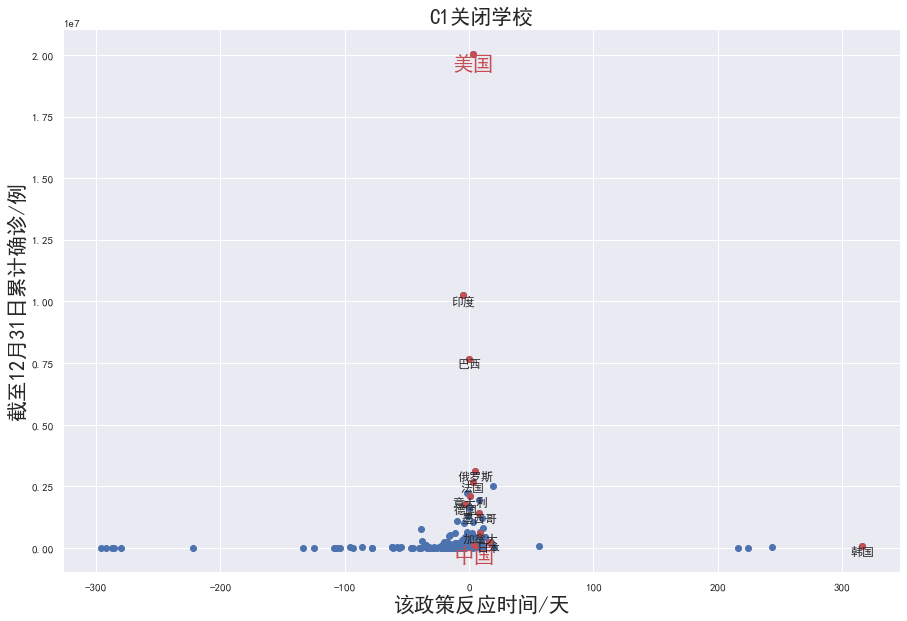

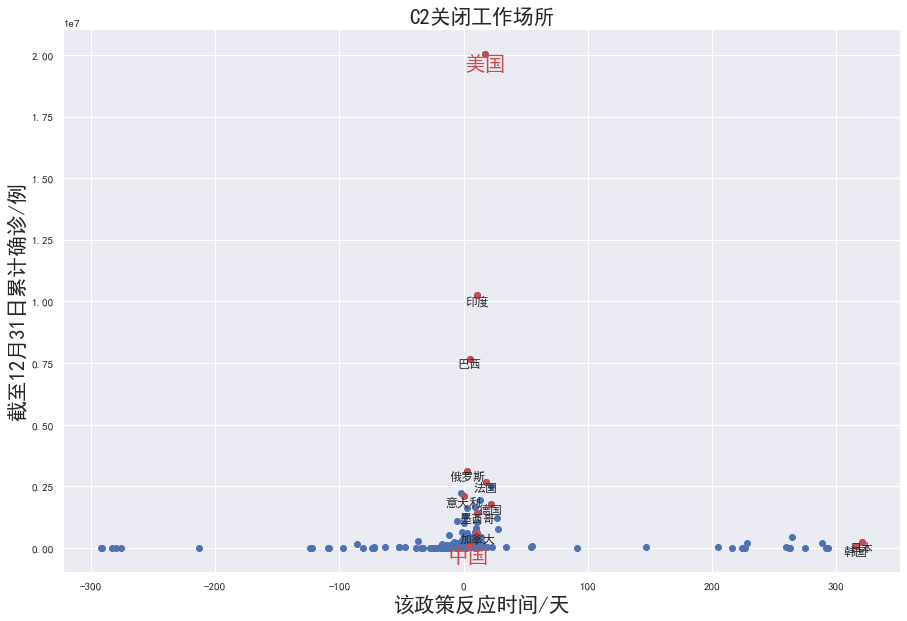

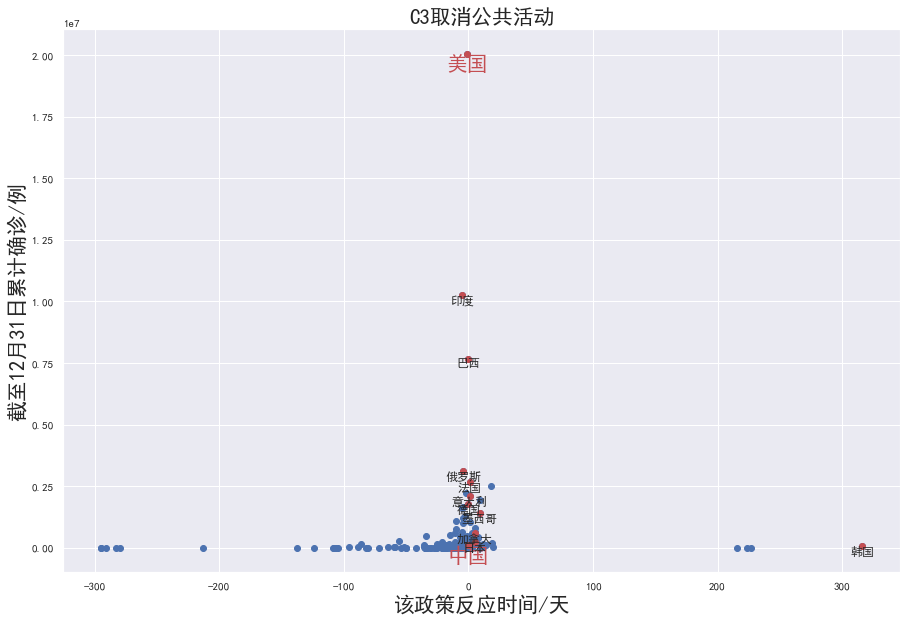

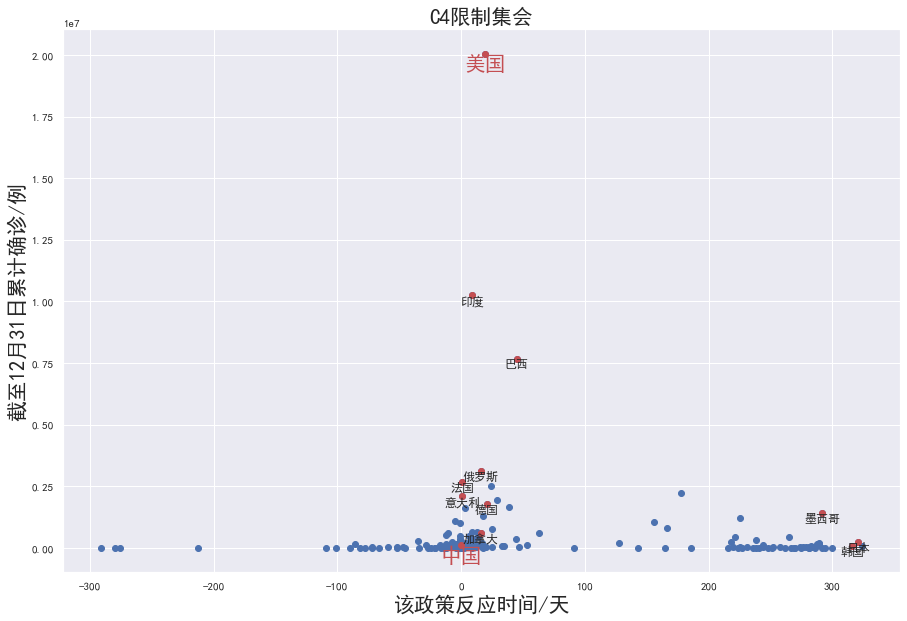

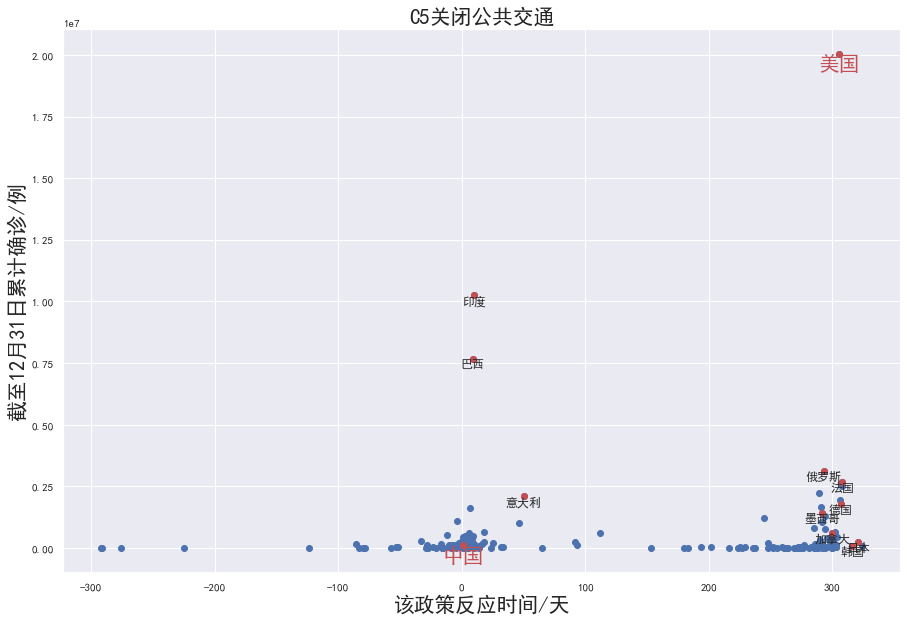

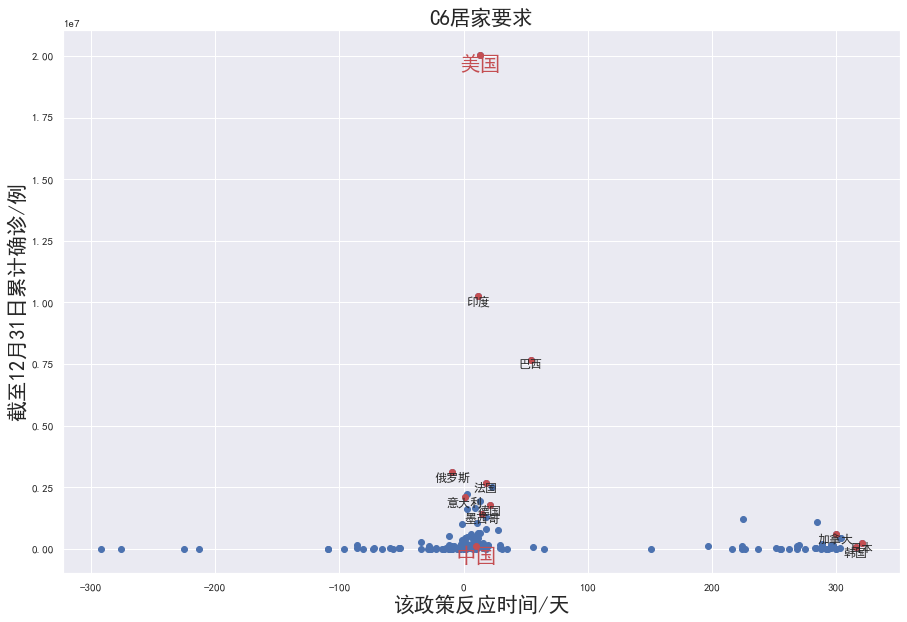

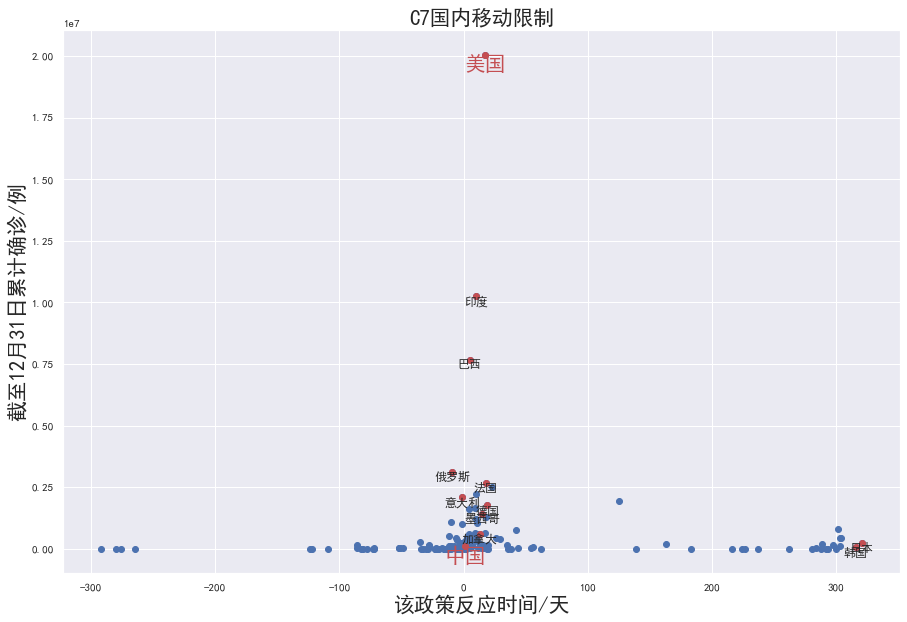

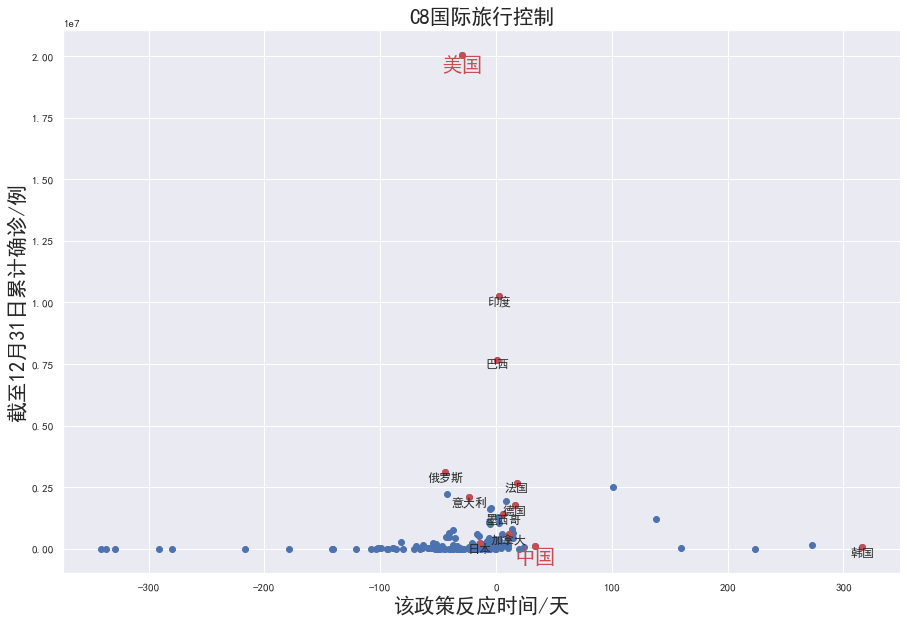

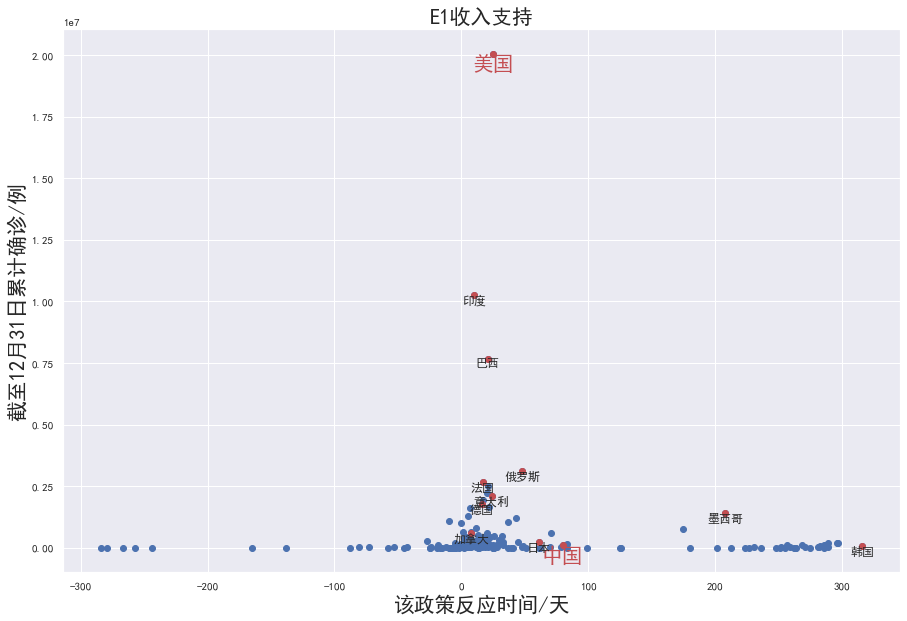

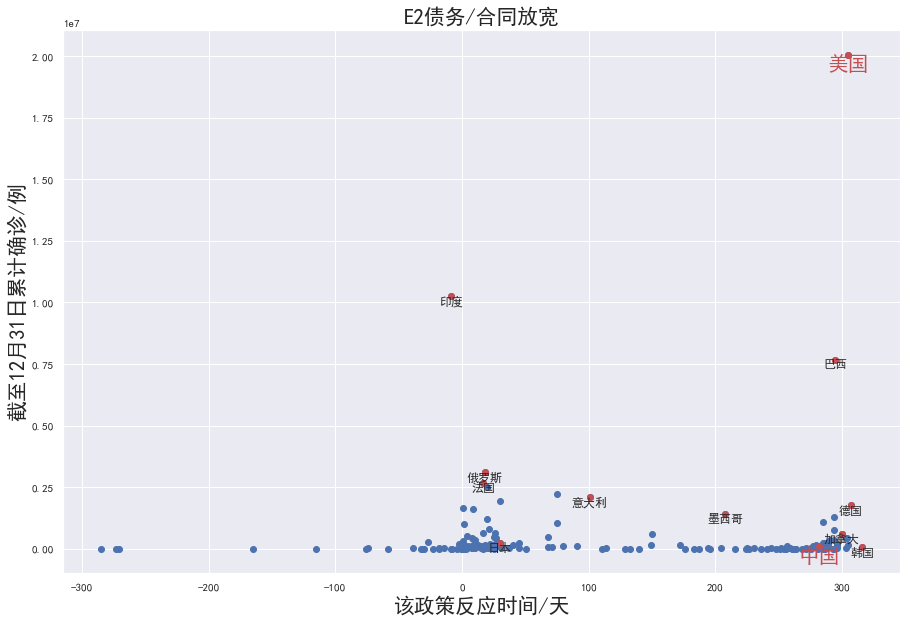

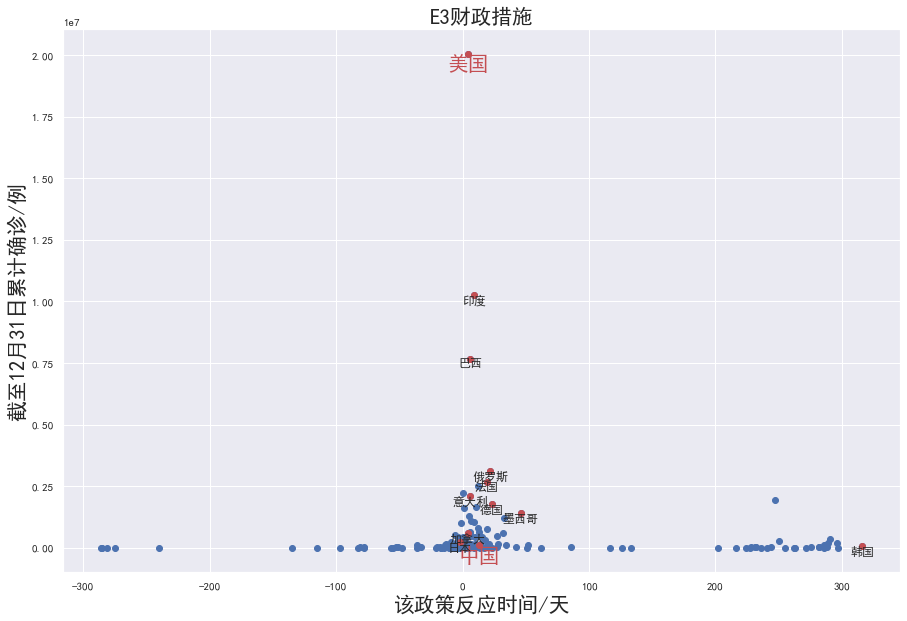

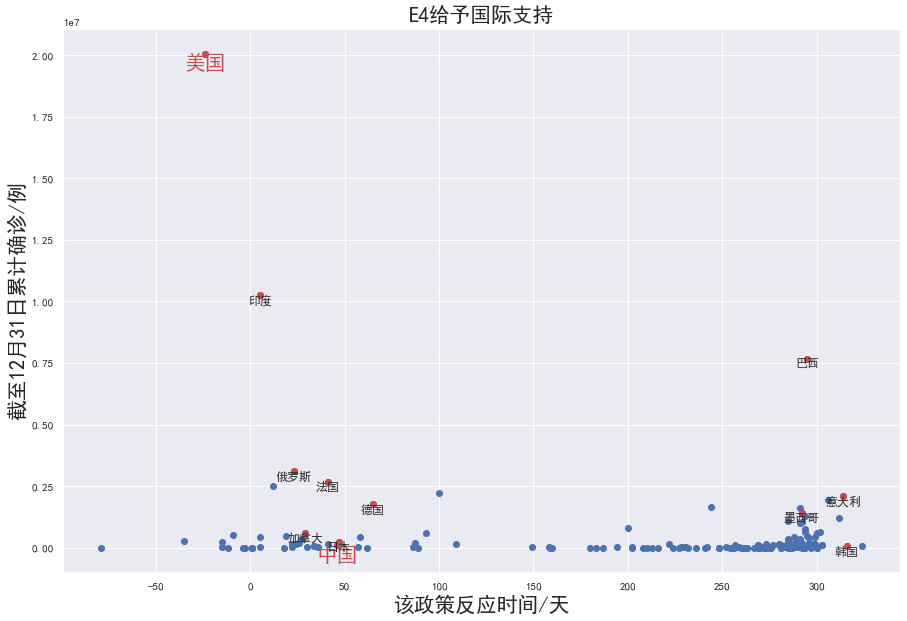

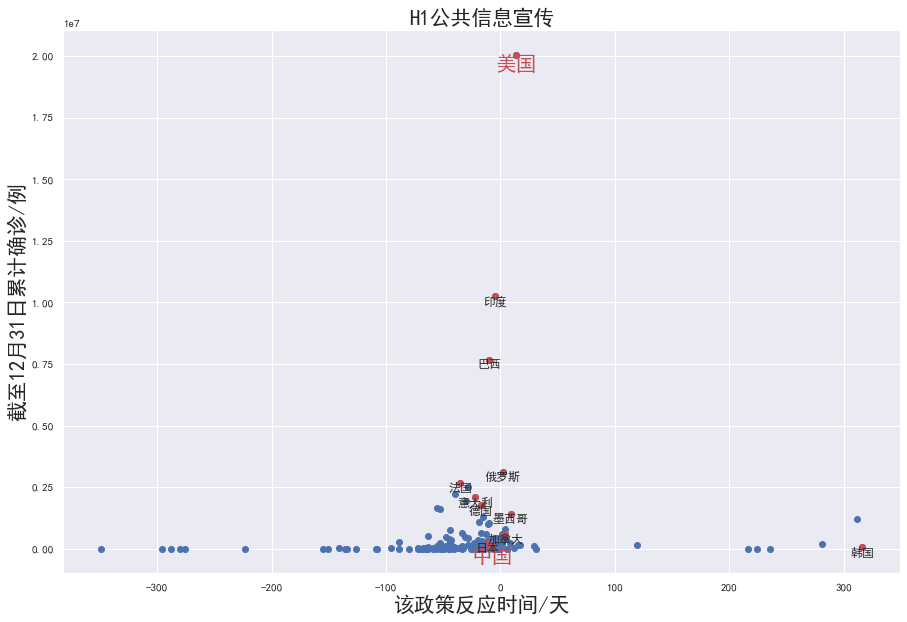

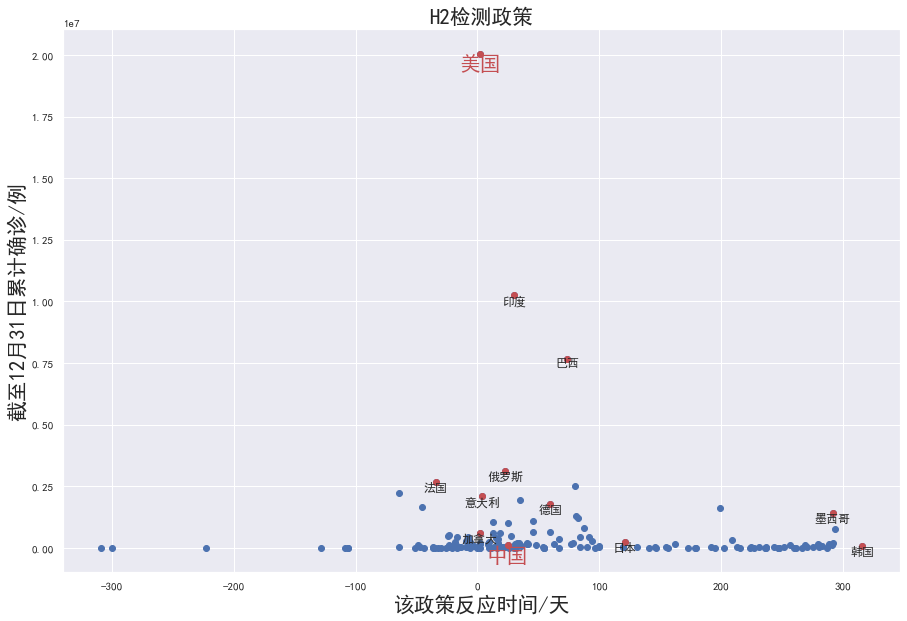

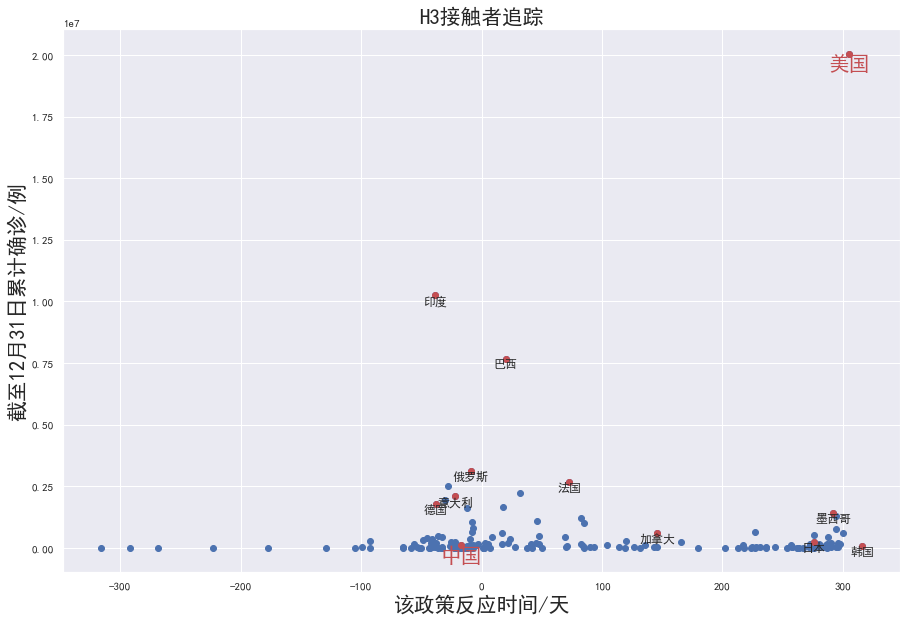

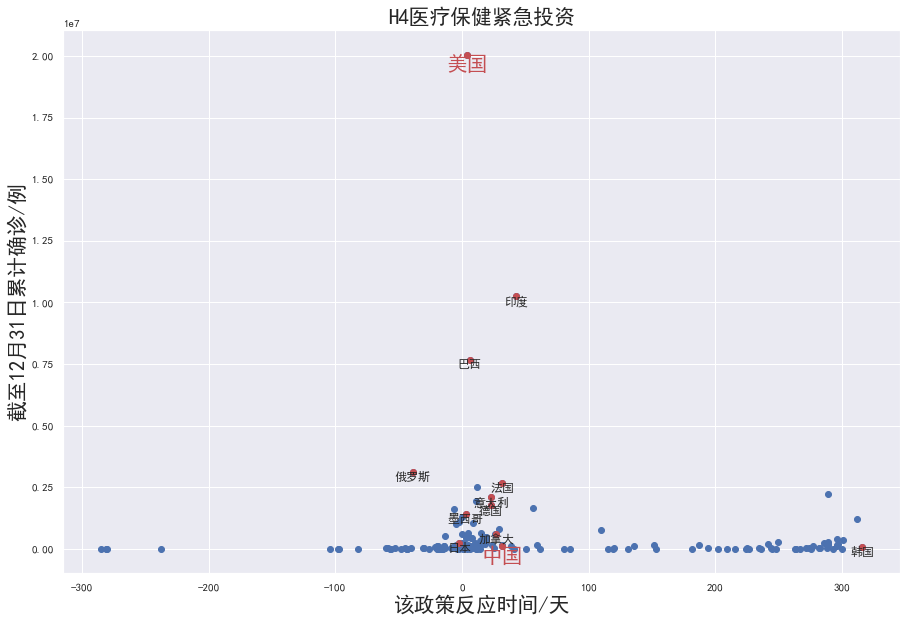

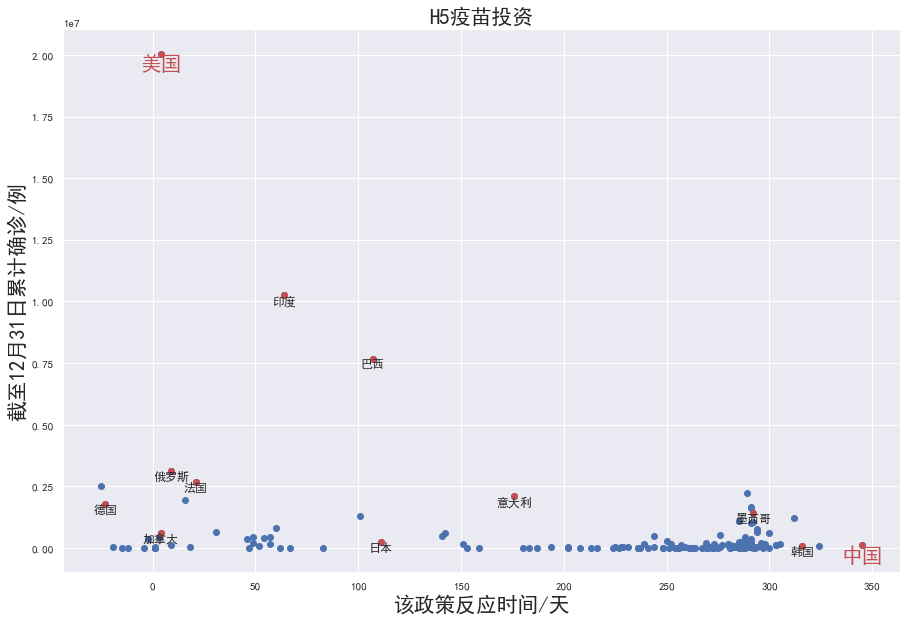

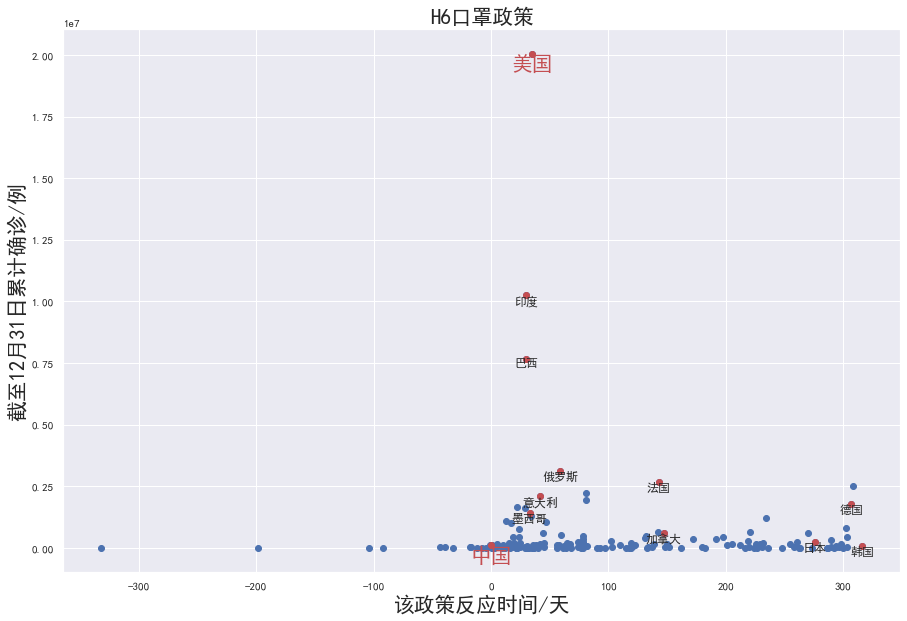

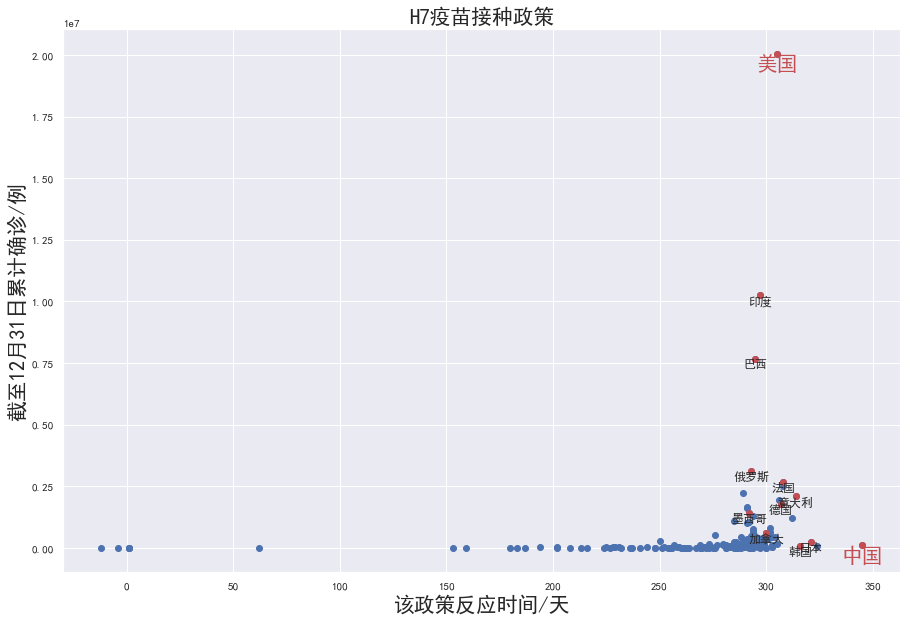

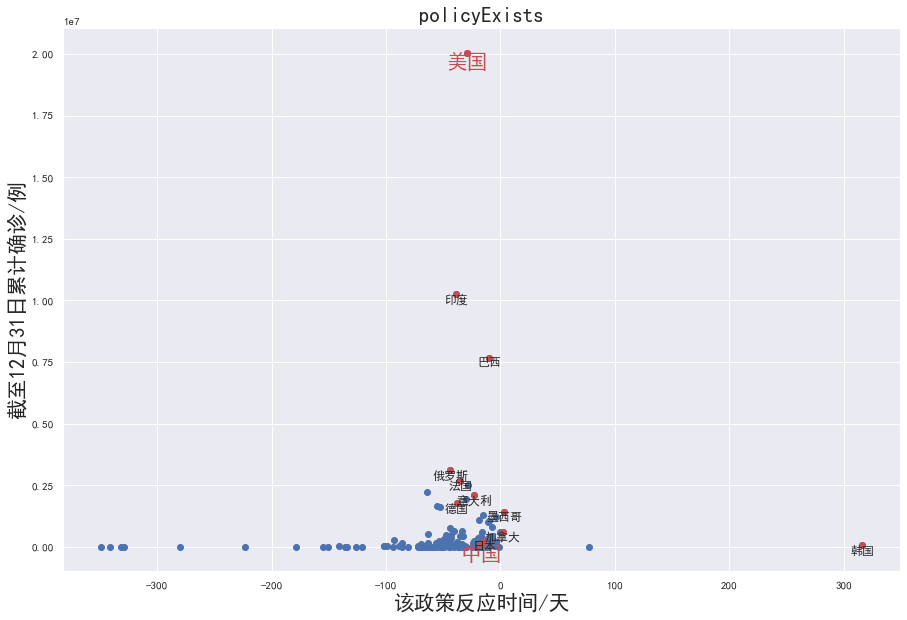

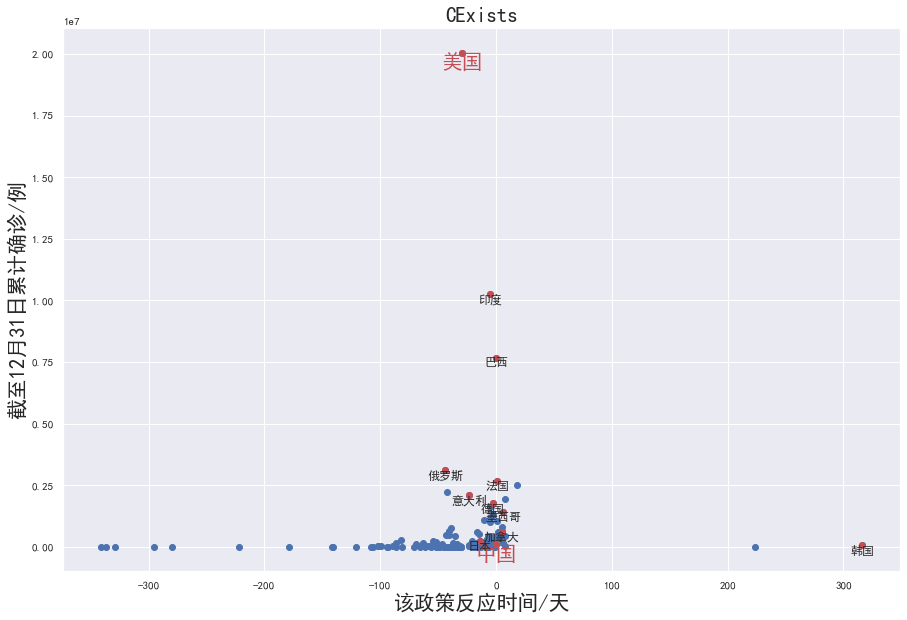

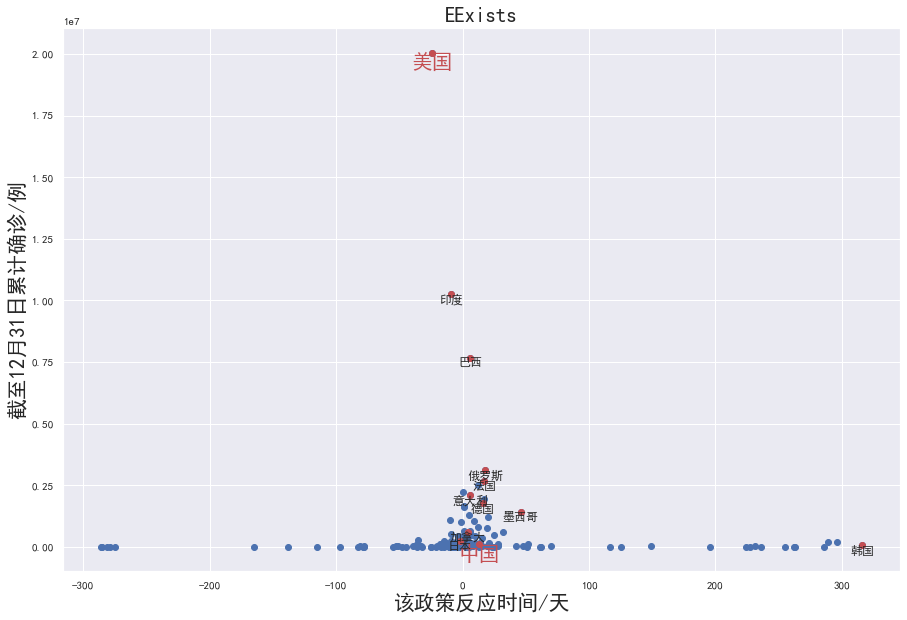

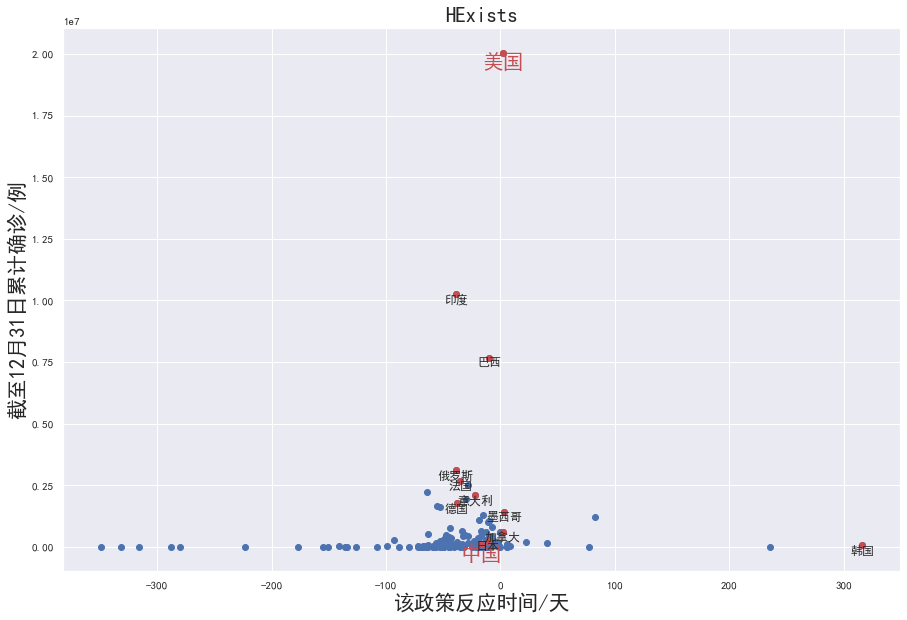

In [26]:
for code in ls_code:
    plt.figure(figsize=(15,10))
    plt.scatter(list(data_scatter['delta'+code]),list(data_scatter['Confirm']))
    # plt.xlim(-370,20)
    plt.scatter(subdata1['delta'+code],subdata1['Confirm'],c='r')
    for i in range(subdata1.shape[0]):
        country = dic_names[subdata1['Country/Region'].iloc[i]]
        if country in ['美国','中国']:
            plt.text(subdata1['delta'+code].iloc[i],subdata1['Confirm'].iloc[i],country,verticalalignment='top',horizontalalignment='center',fontsize='xx-large',c='r')
        else:
            plt.text(subdata1['delta'+code].iloc[i],subdata1['Confirm'].iloc[i],country,verticalalignment='top',horizontalalignment='center')
    title =code + dic_policyChi.get(code,'')
    plt.title(title,fontsize='xx-large')
    plt.xlabel('该政策反应时间/天',fontsize='xx-large')
    plt.ylabel('截至12月31日累计确诊/例',fontsize='xx-large')
    plt.savefig('E:\\Study\\research\\国际疫情分析\\数据处理\\截至到12月\\描述性统计\\时间差和累计确诊\\'+code+'.png')